# Homework 3
**LT2: Alaan, Altonaga, Jalober, Ng**

---

## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import warnings
def showwarning(*args, **kwargs):
    if args[1] is DeprecationWarning:
        return
    warnings._showwarning_orig(*args, **kwargs)
warnings.showwarning = showwarning

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:,.2g}'.format

## Load Dataset

In [138]:
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.6
3,2,mandarin,mandarin,86,6.2,4.7,0.8
4,2,mandarin,mandarin,84,6,4.6,0.79


Fruit_Label Mapping:

1 - Apple

2 - Mandarin

3 - Orange

4 - Lemon

In [139]:
feature_names = ['mass', 'width', 'height', 'color_score']
X = fruits[feature_names]
y = fruits['fruit_label']

## Modelling

### kNN

In [27]:
from sklearn.model_selection import KFold

# we define k-fold Cross-validation with 10 folds
number_folds = 10
kf = KFold(n_splits=number_folds, shuffle=True, random_state=0)

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()
fold = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 50) # try n_neighbors from 1 to 50

    for n_neighbors in neighbors_settings:
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)  # build the model
        clf.fit(X_train, y_train)

        training_accuracy.append(clf.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(clf.score(X_test, y_test))   # record generalization accuracy

    lahat_training[fold] = training_accuracy
    lahat_test[fold] = test_accuracy
    fold += 1

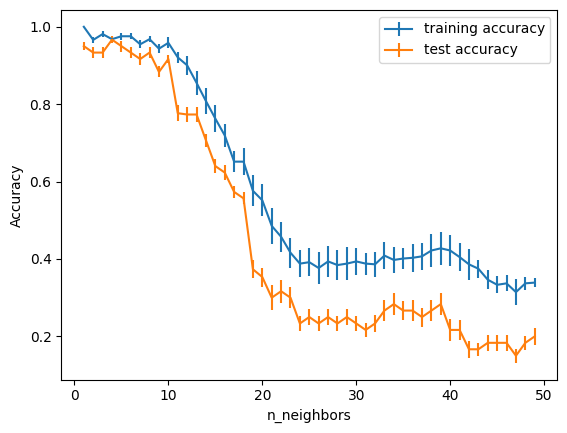

In [30]:
plt.errorbar(neighbors_settings, lahat_training.mean(axis=1),
             yerr=lahat_training.std(axis=1)/2, label="training accuracy")
plt.errorbar(neighbors_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.std(axis=1)/8, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [31]:
print("Best test set mean accuracy: {:.2f}%".format(lahat_test.mean(axis = 1).max() * 100))
print("For k = {}".format(lahat_test.mean(axis = 1).argmax() + 1))

Best test set mean accuracy: 96.67%
For k = 4


### Logistic Regression

#### L2 Regularization

In [63]:
from sklearn.linear_model import LogisticRegression

No_trials = 20

all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,No_trials,1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seedN)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_accuracy = []
    test_accuracy = []

    C = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 1e5, 1e8]

    for alpha_run in C:
        lr_l2 = LogisticRegression(penalty="l2",C=alpha_run).fit(X_train, y_train)
        training_accuracy.append(lr_l2.score(X_train, y_train))
        test_accuracy.append(lr_l2.score(X_test, y_test))
        #print(alpha_run)
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

Highest Test Set Achieved = 0.831579
Best C Parameter = 100000.000000


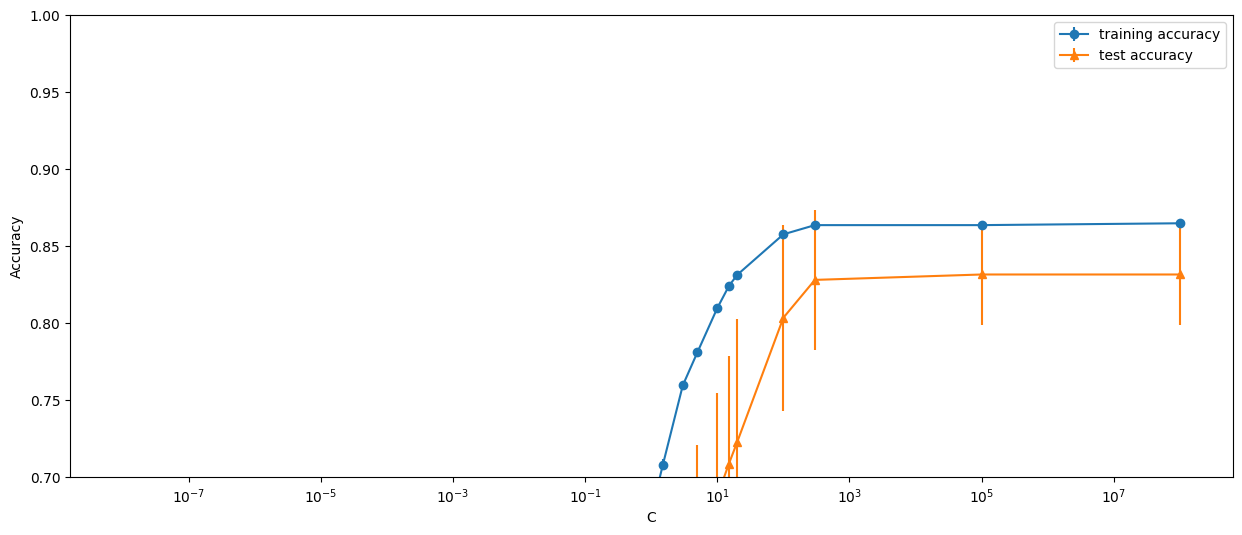

In [64]:
fig = plt.figure(figsize=(15, 6))

plt.xscale('log')
plt.errorbar(C, all_training.mean(axis=1),
             yerr=all_training.var(axis=1), label="training accuracy", marker='o')
plt.errorbar(C, all_test.mean(axis=1), marker='^',
             yerr=5*all_test.var(axis=1), label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.ylim(.7,1)
plt.legend()

print("Highest Test Set Achieved = %f" % np.amax(all_test.mean(axis=1)))
print("Best C Parameter = %f" % C[np.argmax(all_test.mean(axis=1))])

In [ ]:
lr_l2 = LogisticRegression(C=C[np.argmax(all_test.mean(axis=1))]).fit(X_train, y_train)

# print("Top Predictor = %s" %X.columns[np.argmax(lr_l2.coef_.T)])
# print("Top Predictor Weight of ML with highest prediction = %f" %np.amax(lr_l2.coef_.T))

In [69]:
# Find the max *absolute* coefficient for each feature
max_abs_coef_per_feature = np.max(np.abs(lr_l2.coef_.T), axis=0)

# Find the index of the feature with the largest magnitude
top_feature_index = np.argmax(max_abs_coef_per_feature)

# Get the name
top_predictor_name = X.columns[top_feature_index]

# Note: The weight here is the absolute value
top_predictor_weight_magnitude = max_abs_coef_per_feature[top_feature_index]

print("Top Predictor (by magnitude) = %s" % top_predictor_name)
print("Top Predictor Weight (magnitude) = %f" % top_predictor_weight_magnitude)

Top Predictor (by magnitude) = color_score
Top Predictor Weight (magnitude) = 65.845785


#### L1 Regularization

In [72]:
No_trials = 20

lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()
for seedN in range(1,No_trials,1):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seedN)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    training_accuracy = []
    test_accuracy = []

    C = [1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000, 1e5, 1e8]

    for alpha_run in C:

        lr_l1 = LogisticRegression(C=alpha_run, penalty="l1", solver='liblinear').fit(X_train, y_train)
        training_accuracy.append(lr_l1.score(X_train, y_train))
        test_accuracy.append(lr_l1.score(X_test, y_test))

    lahat_training[seedN]=training_accuracy
    lahat_test[seedN] = test_accuracy

Highest Test Set Achieved = 0.740351
Best C Parameter = 5000.000000


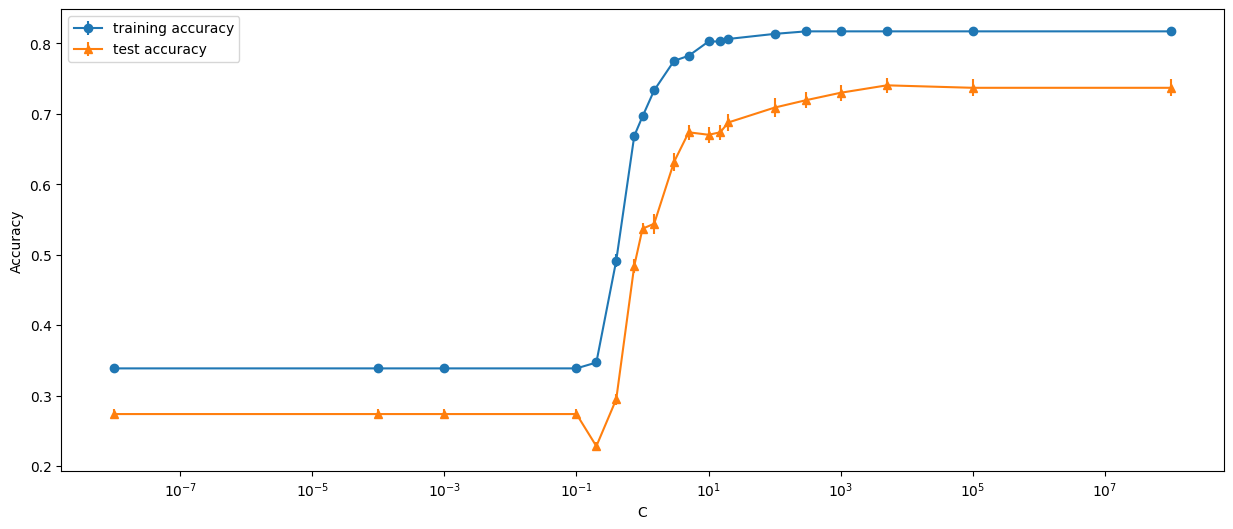

In [73]:
fig = plt.figure(figsize=(15, 6))

plt.xscale('log')
plt.errorbar(C, lahat_training.mean(axis=1),
             yerr=lahat_training.var(axis=1), label="training accuracy", marker='o')
plt.errorbar(C, lahat_test.mean(axis=1), marker='^',
             yerr=lahat_test.var(axis=1), label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
#plt.ylim(.9,1)
plt.legend()
print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best C Parameter = %f" % C[np.argmax(lahat_test.mean(axis=1))])

In [75]:
lr_l1 = LogisticRegression(C=C[np.argmax(lahat_test.mean(axis=1))], penalty="l1", solver='liblinear').fit(X_train, y_train)

# print("Top Predictor = %s" %X.columns[np.argmax(lr_l1.coef_.T)])
# print("Top Predictor Weight of ML with highest prediction = %f" %np.amax(lr_l1 .coef_.T))

In [76]:
# Find the max *absolute* coefficient for each feature
max_abs_coef_per_feature = np.max(np.abs(lr_l1.coef_.T), axis=0)

# Find the index of the feature with the largest magnitude
top_feature_index = np.argmax(max_abs_coef_per_feature)

# Get the name
top_predictor_name = X.columns[top_feature_index]

# Note: The weight here is the absolute value
top_predictor_weight_magnitude = max_abs_coef_per_feature[top_feature_index]

print("Top Predictor (by magnitude) = %s" % top_predictor_name)
print("Top Predictor Weight (magnitude) = %f" % top_predictor_weight_magnitude)

Top Predictor (by magnitude) = color_score
Top Predictor Weight (magnitude) = 60.490420


### Linear SVM

#### L2 Regularization

In [77]:
from sklearn.svm import LinearSVC

No_trials =20

lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()
for seedN in range(1,No_trials,1):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seedN)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_accuracy = []
    test_accuracy = []

    C = [1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000, 1e5, 1e8]

    for alpha_run in C:
        svm_l2 = LinearSVC(C=alpha_run, penalty="l2").fit(X_train, y_train)
        training_accuracy.append(svm_l2.score(X_train, y_train))
        test_accuracy.append(svm_l2.score(X_test, y_test))

    lahat_training[seedN]=training_accuracy
    lahat_test[seedN] = test_accuracy

Highest Test Set Achieved = 0.712281
Best C Parameter = 100000.000000


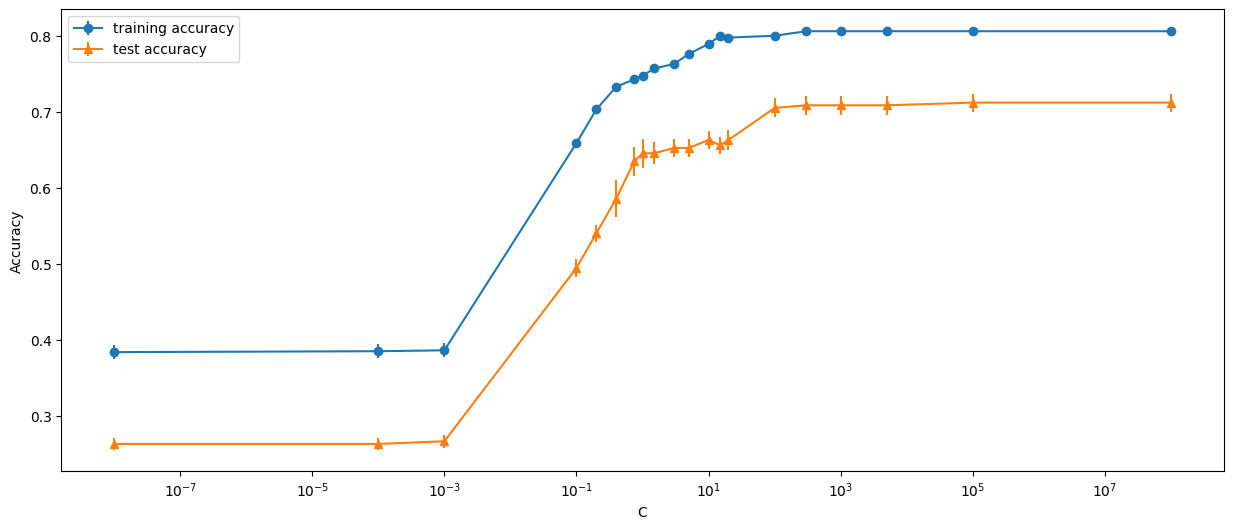

In [78]:
fig = plt.figure(figsize=(15, 6))

plt.xscale('log')
plt.errorbar(C, lahat_training.mean(axis=1),
             yerr=lahat_training.var(axis=1), label="training accuracy", marker='o')
plt.errorbar(C, lahat_test.mean(axis=1), marker='^',
             yerr=lahat_test.var(axis=1), label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
#plt.ylim(.7,1)
plt.legend()

print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best C Parameter = %f" % C[np.argmax(lahat_test.mean(axis=1))])

In [81]:
svm_l2 = LinearSVC(C=C[np.argmax(lahat_test.mean(axis=1))], penalty="l2").fit(X_train, y_train)

# print("Top Predictor = %s" %X.columns[np.argmax(svm_l2.coef_.T)])
# print("Top Predictor Weight of ML with highest prediction = %f" %np.amax(svm_l2 .coef_.T))

In [82]:
# Find the max *absolute* coefficient for each feature
max_abs_coef_per_feature = np.max(np.abs(svm_l2.coef_.T), axis=0)

# Find the index of the feature with the largest magnitude
top_feature_index = np.argmax(max_abs_coef_per_feature)

# Get the name
top_predictor_name = X.columns[top_feature_index]

# Note: The weight here is the absolute value
top_predictor_weight_magnitude = max_abs_coef_per_feature[top_feature_index]

print("Top Predictor (by magnitude) = %s" % top_predictor_name)
print("Top Predictor Weight (magnitude) = %f" % top_predictor_weight_magnitude)

Top Predictor (by magnitude) = color_score
Top Predictor Weight (magnitude) = 10.226367


#### L1 Regularization

In [87]:
No_trials=20

lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()

for seedN in range(1,No_trials,1):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seedN)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_accuracy = []
    test_accuracy = []

    C = [1e-4, 1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000, 1e5, 1e8]

    for alpha_run in C:

        svm_l1 = LinearSVC(C=alpha_run, penalty="l1", loss='squared_hinge', dual=False).fit(X_train, y_train)
        training_accuracy.append(svm_l1.score(X_train, y_train))
        test_accuracy.append(svm_l1.score(X_test, y_test))

    lahat_training[seedN]=training_accuracy
    lahat_test[seedN] = test_accuracy

Highest Test Set Achieved = 0.715789
Best C Parameter = 1000.000000


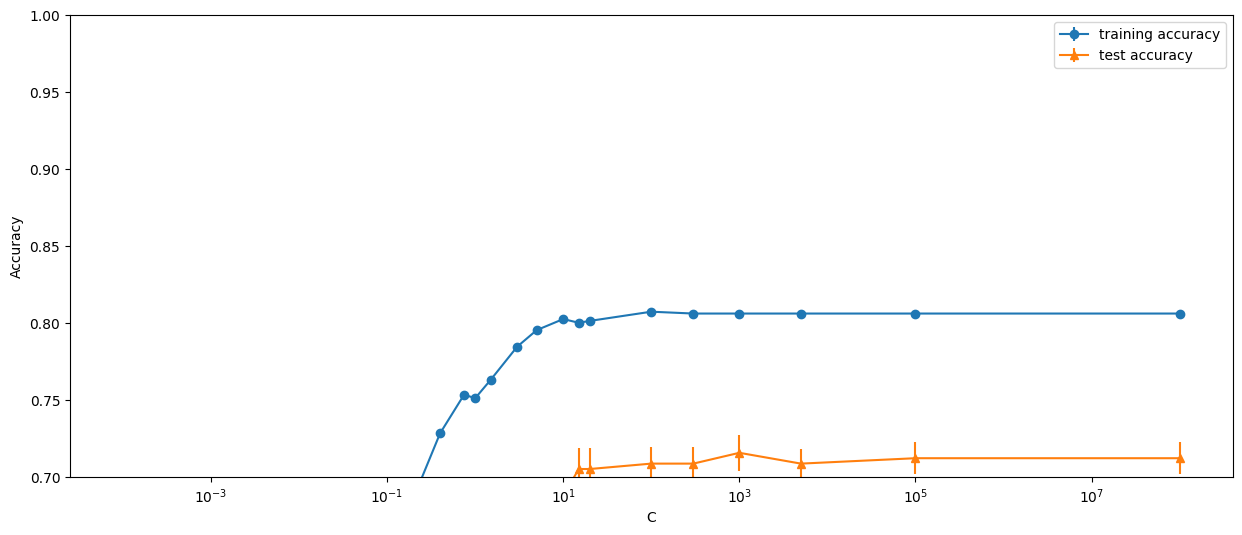

In [88]:
fig = plt.figure(figsize=(15, 6))

plt.xscale('log')
plt.errorbar(C, lahat_training.mean(axis=1),
             yerr=lahat_training.var(axis=1), label="training accuracy", marker='o')
plt.errorbar(C, lahat_test.mean(axis=1), marker='^',
             yerr=lahat_test.var(axis=1), label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.ylim(.7,1)
plt.legend()

print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best C Parameter = %f" % C[np.argmax(lahat_test.mean(axis=1))])

In [91]:
svm_l1 = LinearSVC(C=C[np.argmax(lahat_test.mean(axis=1))], penalty="l1", loss='squared_hinge', dual=False).fit(X_train, y_train)

# print("Top Predictor = %s" %X.columns[np.argmax(svm_l1.coef_.T)])
# print("Top Predictor Weight of ML with highest prediction = %f" %np.amax(svm_l1 .coef_.T))

In [92]:
# Find the max *absolute* coefficient for each feature
max_abs_coef_per_feature = np.max(np.abs(svm_l1.coef_.T), axis=0)

# Find the index of the feature with the largest magnitude
top_feature_index = np.argmax(max_abs_coef_per_feature)

# Get the name
top_predictor_name = X.columns[top_feature_index]

# Note: The weight here is the absolute value
top_predictor_weight_magnitude = max_abs_coef_per_feature[top_feature_index]

print("Top Predictor (by magnitude) = %s" % top_predictor_name)
print("Top Predictor Weight (magnitude) = %f" % top_predictor_weight_magnitude)

Top Predictor (by magnitude) = color_score
Top Predictor Weight (magnitude) = 9.936244


### Random Forest

In [114]:
def plot_feature_importances(model):
    n_features=X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1,n_features)

In [120]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

forest = RandomForestClassifier(n_estimators=100, max_features=2, max_depth=4, random_state=0)
forest.fit(X_train, y_train)
print("accuracy on training set: %f" % forest.score(X_train, y_train))
print("accuracy on test set: %f" % forest.score(X_test, y_test))

accuracy on training set: 1.000000
accuracy on test set: 0.866667


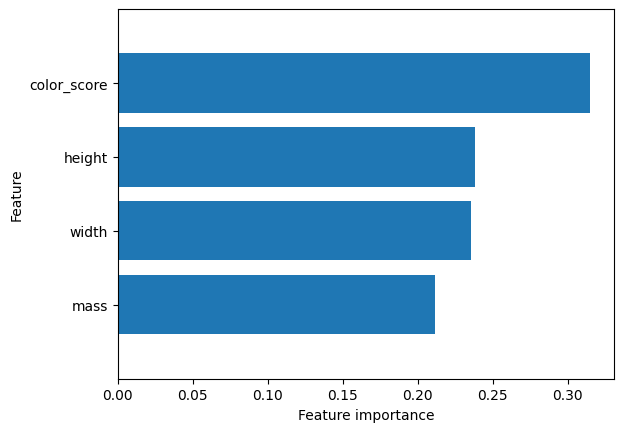

In [121]:
plot_feature_importances(forest)

### GBM

In [132]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

gbrt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

print("accuracy on training set: %f" % gbrt.score(X_train, y_train))
print("accuracy on test set: %f" % gbrt.score(X_test, y_test))

accuracy on training set: 1.000000
accuracy on test set: 0.866667


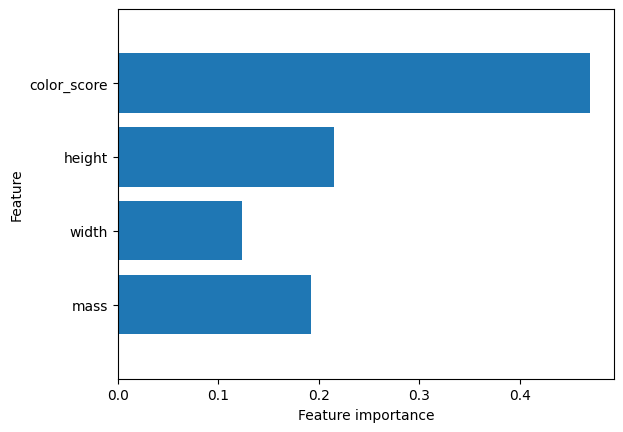

In [133]:
plot_feature_importances(gbrt)

## Summary of Results

## AutoML

In [ ]:
Number_trials=20

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        neighbors_settings = range(1,40)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors) # build the model
            clf.fit(X_train, y_train)
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)

    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'NA',run_time]

def train_logistic(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000, 1e5, 1e8]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear').fit(X_train, y_train)
            if reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False).fit(X_train, y_train)

            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            coefs=lr.coef_
            weighted_coefs.append(coefs) #append all the computed coefficients per trial

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    #print(mean_coefs)
    score = np.mean(score_test, axis=0)

    #Plot the weight of the parameters
    top_predictor=X.columns[np.argmax(np.max(np.abs(mean_coefs), axis=0))]
    abs_mean_coefs = np.abs(mean_coefs[0,:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])

    run_time = (time.time() - start_time)
    return ['Logistic ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor, run_time]

def train_svm(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000, 1e5, 1e8]
    #C = [.01, .1]
    score_train = []
    score_test = []
    weighted_coefs=[]

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.coef_
            weighted_coefs.append(coefs)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials
    score = np.mean(score_test, axis=0)

    top_predictor=X.columns[np.argmax(np.max(np.abs(mean_coefs), axis=0))]
    abs_mean_coefs = np.abs(mean_coefs[0,:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3,7))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])

    run_time = (time.time() - start_time)
    return ['Linear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor,run_time]

['kNN', np.float64(0.9466666666666667), 'N_Neighbor = 1', 'NA', 4.791949987411499]
4.791949987411499 seconds
['Logistic (l2)', np.float64(0.8233333333333335), 'C = 100000.0', 'height', 4.052204132080078]
4.052204132080078 seconds
['Logistic (l1)', np.float64(0.73), 'C = 5000', 'width', 1.6956429481506348]
1.6956429481506348 seconds
['Linear SVM (l2)', np.float64(0.7033333333333333), 'C = 100000.0', 'height', 1.5601608753204346]
1.5601608753204346 seconds
['Linear SVM (l1)', np.float64(0.7), 'C = 1000', 'width', 1.7430140972137451]
1.7430140972137451 seconds


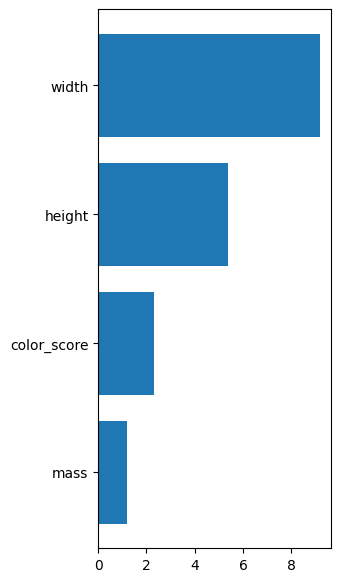

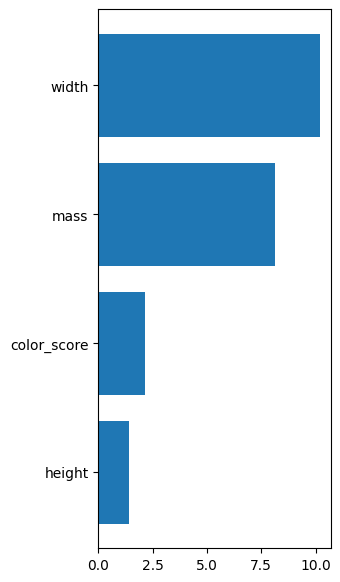

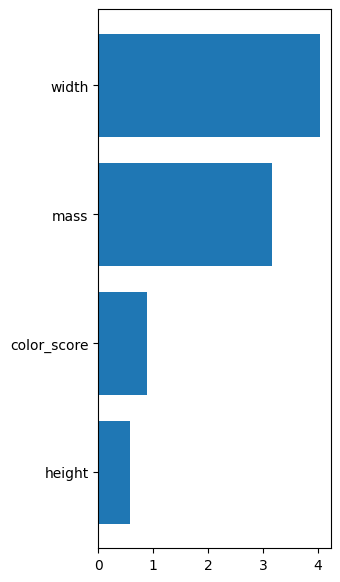

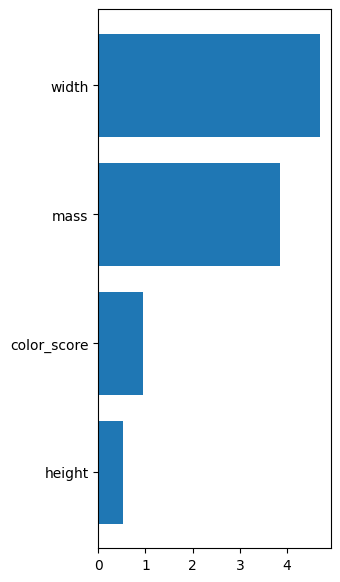

In [145]:
import time

start_time = time.time()
a = train_knn(X,y)
print(a)
print("%s seconds" % a[4])

start_time = time.time()
b = train_logistic(X,y,reg='l2')
print(b)
print("%s seconds" % b[4])

start_time = time.time()
c = train_logistic(X,y,reg='l1')
print(c)
print("%s seconds" % c[4])

start_time = time.time()
d = train_svm(X,y,reg='l2')
print(d)
print("%s seconds" % d[4])

start_time = time.time()
e = train_svm(X,y,reg='l1')
print(e)
print("%s seconds" % e[4])

In [166]:
from sklearn.model_selection import GridSearchCV

def train_rf(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'max_depth': list(range(1, 6)),      # Maximum depth of individual trees
        'max_features': ['sqrt'] # Number of features to consider when looking for the best split
        }

        rf = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_test, y_test))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

In [167]:
start_time = time.time()
f = train_rf(X,y)
print(f)
print("%s seconds" % f[4])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
['Random Forest', np.float64(0.9400000000000001), "{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}", 'color_score', 59.11802697181702]
59.11802697181702 seconds


In [168]:
def train_gbm(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]    # Learning Rate
        }

        gbm = GradientBoostingClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_test, y_test))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

In [169]:
start_time = time.time()
g = train_gbm(X,y)
print(g)
print("%s seconds" % g[4])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
['Gradient Boosting Method', np.float64(0.8866666666666667), "{'learning_rate': 0.5, 'n_estimators': 50}", 'color_score', 113.17141604423523]
113.17141604423523 seconds


## Summary of Results (AutoML)

In [170]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df = pd.DataFrame(columns=cols)

df.loc[0] = a
df.loc[1] = b
df.loc[2] = c
df.loc[3] = d
df.loc[4] = e
df.loc[5] = f
df.loc[6] = g

df

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.95,N_Neighbor = 1,NA,4.8
1,Logistic (l2),0.82,C = 100000.0,height,4.1
2,Logistic (l1),0.73,C = 5000,width,1.7
3,Linear SVM (l2),0.7,C = 100000.0,height,1.6
4,Linear SVM (l1),0.7,C = 1000,width,1.7
5,Random Forest,0.94,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",color_score,59
6,Gradient Boosting Method,0.89,"{'learning_rate': 0.5, 'n_estimators': 50}",color_score,1.1e+02


In [171]:
df.iloc[5, 2]

"{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}"